In [87]:
load("../../dados/vra-wu.RData")
#load("vw.RData")
#vra_wu=vra_wu[0:100000,]

###### Removendo algumas colunas que não devem ter utilizadade


In [ ]:
#Esse é o data set reduzido 'vw_modified'

vra_wu$autho_code = NULL #não sei o que é 
vra_wu$flight = NULL #Codigo do voo
vra_wu$airline = NULL #qual empresa
vra_wu$line_type = NULL #não sei o que é
vra_wu$observation = NULL #não sei o que é
vra_wu$duration_delta = NULL #diferenca de previsão
vra_wu$origin.state = NULL #
vra_wu$destiny.state = NULL #
vra_wu$arrival_expect_date = NULL #arrival_expect
vra_wu$arrival_expect_hour = NULL #arrival_expect
vra_wu$depart_expect_date = NULL #depart_expect
vra_wu$depart_expect_hour = NULL #depart_expect

###### Removendo todas as linhas que tem pelo menos um NA

In [47]:
#efetivamente removendo NA
vra_wu = vra_wu[rowSums(is.na(vra_wu))==0,]

#renomeando
vw <- vra_wu

ERROR: Error in save(vw, "vw.RData"): object 'vw.RData' not found


###### Removendo data de chegada menor que de partida, efetivo e estimado

In [60]:
vw = vw[vw$arrival>vw$depart,]
vw = vw[vw$arrival_expect>vw$depart_expect,]

###### Validando níveis de temperatura de forma exploratória

In [ ]:
min(vw$depart_temperature) #OK
max(vw$depart_temperature) #OK
min(vw$arrival_temperature) #OK
max(vw$arrival_temperature) #OK

###### pegando atrasos somente de 15min até 4 horas e que tem status 'Realizado'

In [61]:
vw = vw[vw$departure_delay >15 & vw$departure_delay <240 & vw$status=="Realizado",]

###### Top 5 aeroportos em contagem de atrasos de partida no brasil

In [64]:
library(dplyr)
vw_g = vw[c("origin")]
vw_g = vw_g %>% group_by(origin) %>% summarize(Count = n())
head(vw_g[order(-vw_g$Count),])
#SBGR=guarulhos, SBBR=brasilia, SBSP=congonhas, SBGL=galeão, SBSV=salvador, SBCF=belo horizonte

origin,Count
SBGR,65545
SBBR,35867
SBSP,33740
SBGL,32406
SBSV,30416
SBCF,22318


##### Análise do aeroporto de guarulhos

ERROR: Error in Ops.POSIXt(x, 2): '^' not defined for "POSIXt" objects


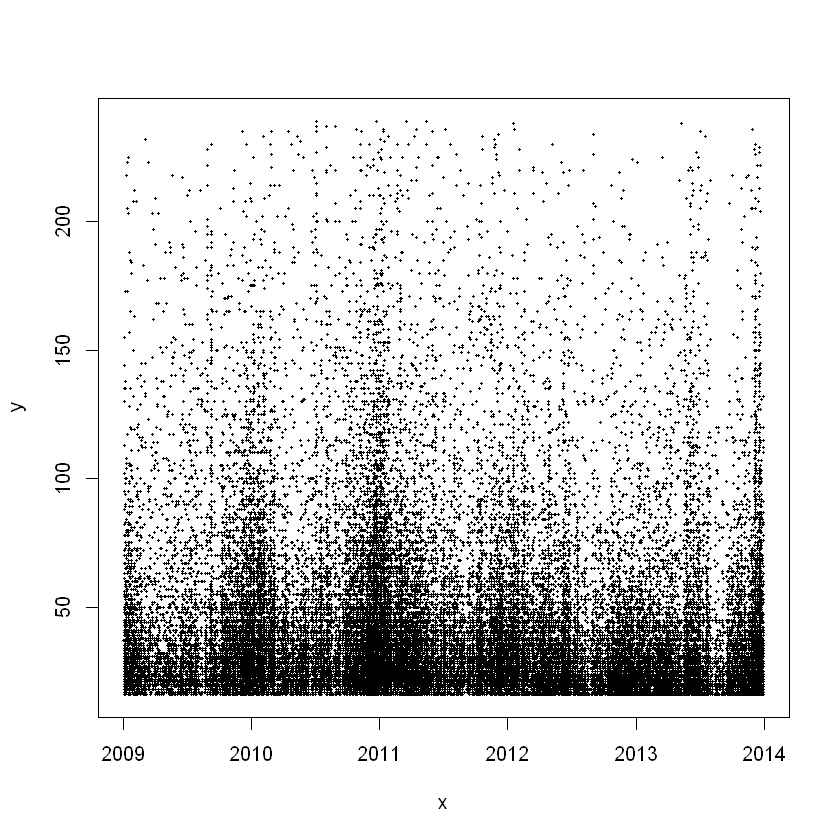

In [81]:
#vw_sbgr = vw[vw$origin == 'SBGR',]
#Filtrando 2014 pois 2016 e 2016 não estão completos
filter = vw_sbgr$depart$year+1900<2014 
x = vw_sbgr$depart[filter]
y = vw_sbgr$departure_delay[filter]
plot(x,y,pch=16 , cex=0.3)
#str(vw)

In [93]:
#dim(vra_wu)
#a=colSums(is.na(vra_wu))

[1] 8683195      37

In [99]:
a[order(-a)]

arrival_visibility   depart_visibility       depart_events      arrival_events 
            2647816             2630157             1610187             1604697 
      arrival_delay      duration_delta     departure_delay     depart_pressure 
            1207611             1207611             1207610              951969 
   arrival_pressure             arrival            duration              depart 
             937069              830419              830419              830418 
  arrival_dew_point    depart_dew_point   depart_conditions  arrival_conditions 
             711880              707385              629570              625332 
   arrival_humidity     depart_humidity arrival_temperature  depart_temperature 
             589197              588613              581796              581273 
       origin.state       destiny.state arrival_expect_date arrival_expect_hour 
             455090              449946              377196              377196 
 depart_expect_date  depart_expect_hour       depart_expect      arrival_expect 
             377196              377196              377196              377196 
    duration_expect             destiny              origin             airline 
             377196                   0                   0                   0 
             flight          autho_code           line_type              status 
                  0                   0                   0                   0 
        observation 
                  0

Small delays < 300 min
Only considering flight with a delay, removing delay = 0

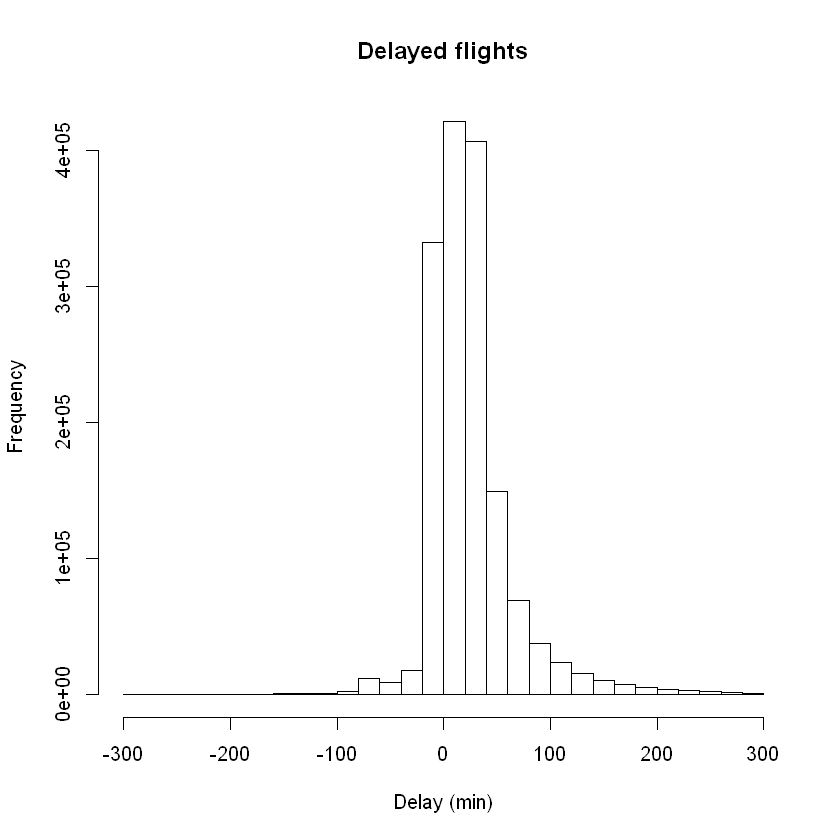

In [2]:
data=vra_wu[complete.cases(vra_wu$departure_delay),]
hist(data$departure_delay[data$status=="Realizado" 
      & data$departure_delay != 0 
      & abs(data$departure_delay) < 300]
     ,breaks=30
     ,xlim=c(-300,300)
     ,xlab="Delay (min)"
     ,main="Delayed flights"
     )
rm(data)

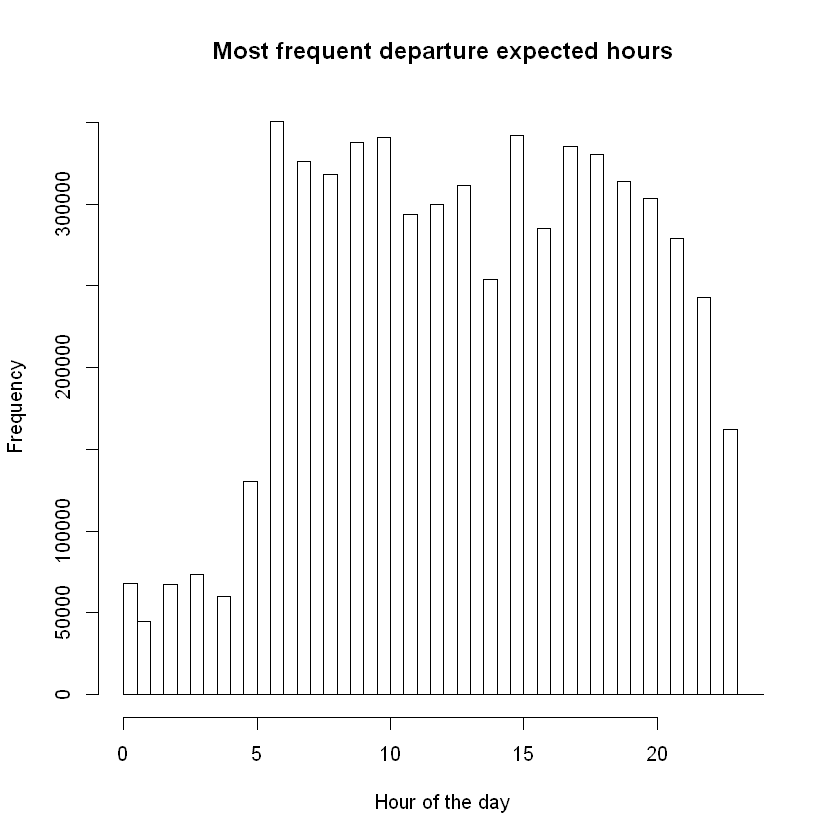

In [5]:
data=vra_wu[complete.cases(vra_wu$depart_expect_hour),]
deh = as.POSIXct(data$depart_expect_hour[data$status=="Realizado"], format="%H:%M")
deh = as.POSIXlt(deh)

h=hist(deh$hour+deh$min/60
     ,breaks=seq(0, 24, 0.5)
     ,xlim=c(0,24)
     ,xlab="Hour of the day"
     ,main="Most frequent departure expected hours"
     )
rm(data,deh)

In [21]:
library(data.table)
airport = fread("https://raw.githubusercontent.com/gustavoP/DMcefet/master/airports_simplified.csv")

In [22]:
library(dplyr)
vra_wu = vra_wu[c("origin", "destiny")]
vra_wu = vra_wu %>% group_by(destiny,origin) %>% summarize(Count = n())

library(tidyverse)
vra_wu$destiny = as.character(vra_wu$destiny)
vra_wu$origin = as.character(vra_wu$origin)
vra_wu = vra_wu %>%
    rowwise() %>%
    mutate(grp = paste0(sort(c(destiny, origin)), collapse = "_")) %>%
    ungroup() %>%
    group_by(grp) %>%
    summarise(Count = sum(Count)) %>%
    separate(grp, into = c("destiny", "origin"))

dim(vra_wu)

[1] 1087    3

Filtrando alguns casos:
1) SaÃ­da e destino para o mesmo lugar.

In [23]:
#Join Departure
vra_wu= merge(vra_wu,airport, by.x="destiny", by.y="ICAO")
colnames(vra_wu)[colnames(vra_wu) == "name"] = "destiny_airport_name"
colnames(vra_wu)[colnames(vra_wu) == "city"] = "destiny_city"
colnames(vra_wu)[colnames(vra_wu) == "country"] = "destiny_country"
colnames(vra_wu)[colnames(vra_wu) == "latitude"] = "destiny_latitude"
colnames(vra_wu)[colnames(vra_wu) == "longitude"] = "destiny_longitude"

#Join Origin
vra_wu= merge(vra_wu,airport, by.x="origin", by.y="ICAO")
colnames(vra_wu)[colnames(vra_wu) == "name"] = "origin_airport_name"
colnames(vra_wu)[colnames(vra_wu) == "city"] = "origin_city"
colnames(vra_wu)[colnames(vra_wu) == "country"] = "origin_country"
colnames(vra_wu)[colnames(vra_wu) == "latitude"] = "origin_latitude"
colnames(vra_wu)[colnames(vra_wu) == "longitude"] = "origin_longitude"

In [12]:
#install.packages("tidyverse")
#install.packages("maps")
#install.packages("geosphere")

Warning message:
"package 'tidyverse' is in use and will not be installed"Warning message:
"package 'maps' is in use and will not be installed"also installing the dependency 'sp'



package 'sp' successfully unpacked and MD5 sums checked
package 'geosphere' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\g_pac\AppData\Local\Temp\Rtmp2viOcP\downloaded_packages


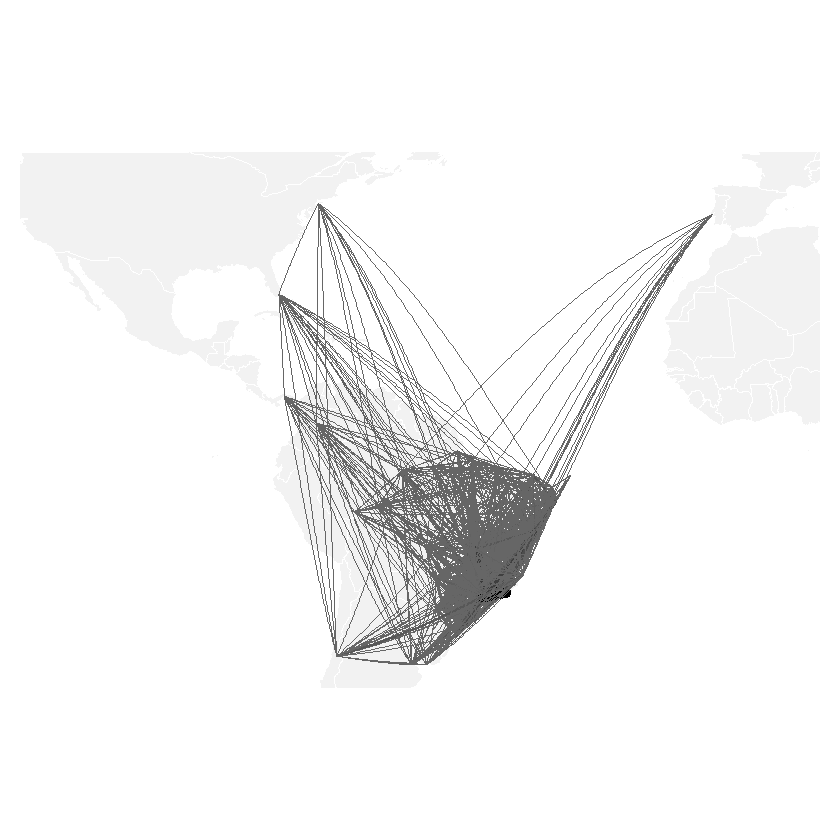

In [27]:
library(tidyverse)
library(maps)
library(geosphere)

par(mar=c(0,0,0,0))
map('world',col="#f2f2f2", fill=TRUE, bg="white", lwd=0.05,mar=rep(0,4),border=0, resolution=0, ylim = c(-37.580515,47.988991), xlim = c(-121.471841,7.200034))
pal <- colorRampPalette(c("#666666", "black"))
colors <- pal(30)

max_cnt = max(vra_wu$Count)
min_cnt = min(vra_wu$Count)
lwd_max = 10
lwd_min = 0.8


for (j in 1:dim(vra_wu)[1]) {
    #j=15*i
    origin = c(vra_wu$origin_longitude[j],vra_wu$origin_latitude[j])
    destiny = c(vra_wu$destiny_longitude[j],vra_wu$destiny_latitude[j])
     
    inter = gcIntermediate(origin, destiny, n=100, addStartEnd=TRUE)
    pu = (vra_wu$Count[j] -min_cnt)/(max_cnt-min_cnt)
    col_index =1+ round(pu*(length(colors)-1))
    lin = pu*(lwd_max-lwd_min)+lwd_min
    lines(inter, col=colors[col_index],lwd=lin)
    #lines(inter, col="#666666",lwd=0.5)
    #min=0.8
    #if (i==100){break}
}
